# Moment Tensor Amplitude Inversion

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sp
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

from pylops.basicoperators import HStack, VStack
from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.optimization.sparsity import *


In [2]:
from pyfrac.mtsolvers.homo_mti import collect_source_angles, pwave_Greens_comp
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict
from pyfrac.mtsolvers.mtai import *
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.visualisation.eventimages import locimage3d

# Load eFD Data

In [3]:
data_dir = '../../data/pyfrac_SOFIModelling'

In [4]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

In [5]:
# RECEIVERS
recs_xzy = np.loadtxt(os.path.join(data_dir,'inputs/griddedarray_xzy_20m.dat')).T
nr = recs_xzy.shape[1]
print(nr)


143


In [18]:
expname = 'MT-90-90-180_Homogeneous_griddedarray'

# Vz is Vy 
vz = read_seis(os.path.join(data_dir,'outputs/su/%s_vy.txt'%expname), 
               nr=143)

dt = 1e-3 #ms
t_shift = 160
tdur = 500

vz = vz[:,t_shift:t_shift+tdur]
vz /= np.max(abs(vz))

# 3D Model & Source Params

In [7]:
abs_bounds = 30
dx = dy = dz = 5
nx = 112
ny = 128
nz = 120
print(nx,ny,nz)

mod_w_bounds = np.fromfile(os.path.join(data_dir,'inputs/models/Homogeneous_xyz.vp'),dtype='float32').reshape([nx,ny,nz])

# Remove absorbing boundaries
mod = mod_w_bounds[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,:-abs_bounds] # z has free surface
nx, ny, nz = mod.shape
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz
print(nx,ny,nz)
recs = np.array([recs_xzy[0]-(abs_bounds*dx),recs_xzy[2]-(abs_bounds*dx),recs_xzy[1]])

112 128 120
52 68 90


In [8]:
# Source Parameters
omega_p = 20 

sx = nx//2
sy = ny//2
sz = 2*nz//3
sloc_ind =[sx,sy,sz]

## Get all necessary components

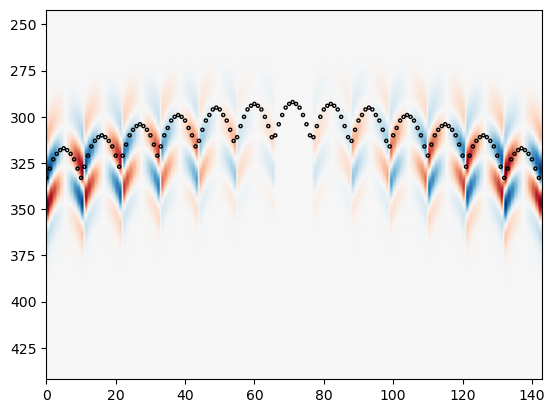

In [19]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs,  
                                   vel=mod, 
                                   mode='eikonal')

TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

source_times = np.round(TTT_full[:, sloc_ind[0], sloc_ind[1], sloc_ind[2]]/dt).astype(int)

vz_amps = np.ones(nr)
for i in range(nr):
    vz_amps[i] = vz[i,source_times[i]]



In [ ]:
plt.imshow(vz[:,np.min(source_times)-50:150+np.min(source_times)].T, aspect='auto',
           extent=[0, nr, 150+np.min(source_times), np.min(source_times)-50],
           cmap='RdBu',
          )
plt.scatter(range(nr),source_times, marker='o', facecolors='none', edgecolors='k', s=5)

p_amps = vz_amps

In [10]:
# AMPLITUDE TERMS
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

In [11]:
# Source Parameters
omega_p = 30  # Assume central frequency of 25Hz
# sloc_ind = [nx//2, ny//2, nz//2]  # As indices of velocity model

In [12]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for area of interest

In [13]:
Gz = pwave_Greens_comp(gamma_sourceangles,
                        dist_table,
                        sloc_ind,
                        mod,
                        MT_comp_dict,
                        comp_gamma_ind=2,
                        omega_p=omega_p,
                        )

In [14]:
Gz.shape

(6, 143)

# Single Event Example

In [15]:
# Modelled MT
mt = np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 

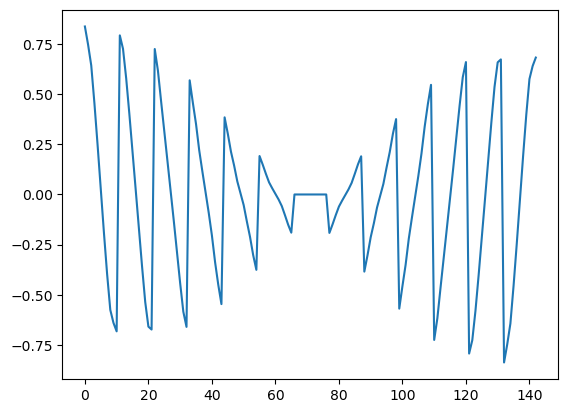

In [20]:
# Forward
# p_amps = frwrd_mtmodelling(Gz, mt)
plt.plot(p_amps)

[ 3.38760417e-07  1.62780485e-07 -8.64856148e-09  1.00000000e+00
 -1.23884901e-06  1.05233902e-02]
[-3.38760417e-07 -1.62780485e-07  8.64856148e-09  0.00000000e+00
  1.23884901e-06 -1.05233902e-02]


Text(0.5, 1.0, 'MT Amplitude Inversion')

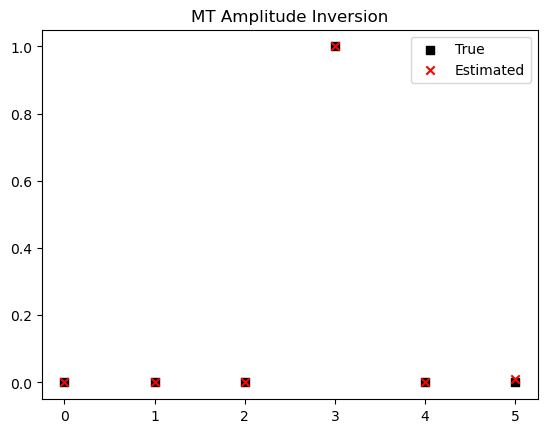

In [21]:
# LSQR Inversion
mt_est = lsqr_mtsolver(Gz, p_amps)
mt_est /= np.max(abs(mt_est))
print(mt_est)
print(mt-mt_est)

plt.scatter(range(6), mt, c='k', marker='s', label='True')
plt.scatter(range(6), mt_est, c='r', marker='x', label='Estimated')
plt.legend()
plt.title('MT Amplitude Inversion')